In [1]:
import pandas as pd
import numpy as np
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tqdm import tqdm
import wordcloud
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import seaborn as sns 
from textblob import TextBlob
from collections import defaultdict

from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from scipy.spatial.distance import euclidean

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/beatricenobile/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatricenobile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/beatricenobile/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
data = pd.read_csv('Reviews.csv')
data.shape

(568454, 10)

In [3]:
print(data.isnull().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [5]:
#data clean up
data.ProfileName.fillna('', inplace=True)
data.Summary.fillna('', inplace=True)
data.set_index('Id', inplace = True) #Id has become our index
data.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.iloc[0].Time

1303862400

In [7]:
pd.to_datetime(data.iloc[0].Time*1000) #to get seconds

Timestamp('1970-01-01 00:21:43.862400')

In [8]:
data['Datetime'] = data.Time.apply(lambda val: pd.to_datetime(val,unit='s'))

# Some Initial Visualization

Distibution of the score 1to5

<AxesSubplot:>

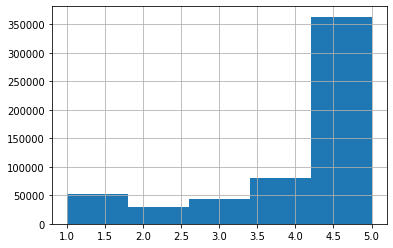

In [9]:
data['Score'].hist(bins=5)

As we can see most of the ratings are above 4.0

Number of ratings per products

<AxesSubplot:ylabel='Frequency'>

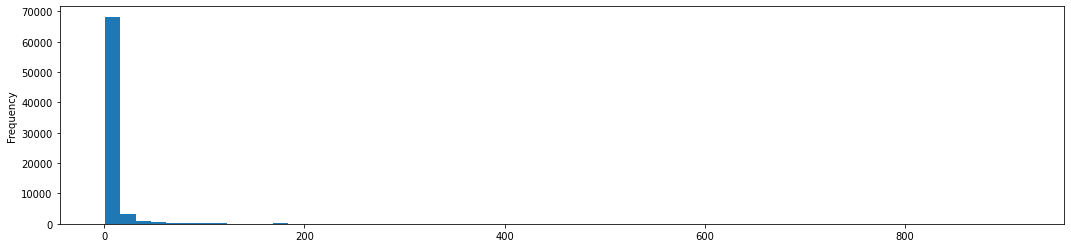

In [10]:
ratPprod = data.groupby(['ProductId']).Score.count()
ratPprod.plot.hist(bins=60, figsize=(18,4))

In [12]:
len(data.ProductId.unique())

74258

Yet, the ratings per products are extremely skewed, and only few products have a really high number of ratings, while most have only under 100 ratings.

Visual analysis of data

In [15]:
data.groupby(data.Datetime.dt.month).count()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime
Datetime,,,,,,,,,,
1,50367,50367,50367,50367,50367,50367,50367,50367,50367,50367
2,45356,45356,45356,45356,45356,45356,45356,45356,45356,45356
3,48367,48367,48367,48367,48367,48367,48367,48367,48367,48367
4,44473,44473,44473,44473,44473,44473,44473,44473,44473,44473
5,46226,46226,46226,46226,46226,46226,46226,46226,46226,46226
6,44479,44479,44479,44479,44479,44479,44479,44479,44479,44479
7,48419,48419,48419,48419,48419,48419,48419,48419,48419,48419
8,50526,50526,50526,50526,50526,50526,50526,50526,50526,50526
9,55740,55740,55740,55740,55740,55740,55740,55740,55740,55740


Heatmap of scores vs month

<AxesSubplot:>

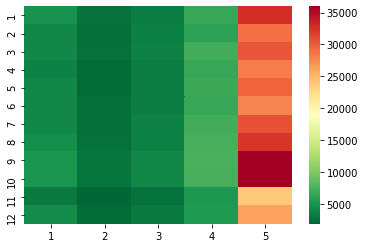

In [16]:
dt=data.groupby([data.Datetime.dt.month,data.Score]).ProductId.count()

d={}
for month in range(1,13):
    d[month]=dt[month].tolist()
sns.heatmap(pd.DataFrame.from_dict(d,orient='index',columns=[1,2,3,4,5]), cmap='RdYlGn_r')

## Look into the text

The first thing we have done is preprocessing the text so as to have the terms ready for the TFIDF Vectorizer. In particular, we have removed the punctuation, handled irregular verbs, stemmed the data using the Porter Stemmer, and finally we have removed the stop words. Please notice that we have exported the final column, so as not to run the code more than once, therefore we import the column later from an external csv. 

In [ ]:
################################################################################################################
################################################## DO NOT RUN ##################################################
################################################################################################################
stop_words = set(stopwords.words('english'))
stemming = PorterStemmer()

irregulars = pd.read_csv("irregular_verbs.csv", sep=";", header=0, encoding='utf8')
irregulars.columns = ['inf', 'sp', 'pp']

def irregular_verbs(row):
    new_row = []
    for word in row:
      if word not in irregulars['sp'].to_list() and word not in irregulars['pp'].to_list():
        new_row.append(word)
        continue
      else:
        for i in range(irregulars.shape[0]):
          if word == irregulars['sp'][i]:
            new_row.append(irregulars['inf'][i])
            continue
          if word == irregulars['pp'][i]:
            new_row.append(irregulars['inf'][i])
            continue
    return new_row

def clean_text(row):

    # tokenize
    tokens = nltk.word_tokenize(row)
    token_words = [w for w in tokens if w.isalpha()]
    # stem irregular verbs
    tokens_vrbs = irregular_verbs(token_words)
    # stem all other terms
    stemmed = [stemming.stem(word.lower()) for word in tokens_vrbs if len(stemming.stem(word.lower()))>2]
    # remove stop words
    meaningful_words = [w for w in stemmed if not w in stop_words]

    return meaningful_words


data['text_words'] = data['Text'].apply(clean_text)

#print(data['text_words'][1])

new_column = pd.DataFrame(data['text_words'])
new_column['text_words'] = ['-'.join(i) for i in new_column['text_words']]
new_column.to_csv('new_column.csv', index=False)

################################################################################################################
################################################################################################################

In [14]:
################################################################################################################
################################################## DO NOT RUN ##################################################
################################################################################################################

vocabulary = []
for text in data['text_words']:
  for word in text :
    if word not in vocabulary:
      vocabulary.append(word)

vocab = pd.DataFrame(vocabulary)
vocab.to_csv('vocabulary.csv', index=False)

################################################################################################################
################################################################################################################

In [3]:
vocabulary = pd.read_csv('vocabulary.csv')
vocabulary.columns = ['terms']
vocabulary = vocabulary['terms'].to_list()
vocabulary.remove(vocabulary[15940])
vocabulary.remove(vocabulary[34437])

new_column = pd.read_csv('new_column.csv')
new_column['text_words'] = [i.split('-') if type(i) != float else "" for i in new_column['text_words'].to_list() ]
data['text_words'] = new_column['text_words'].to_list()
data['words'] = [' '.join(i) for i in data['text_words']]

In [5]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_words,words
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[buy, sever, vital, dog, food, product, find, ...",buy sever vital dog food product find good qua...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[product, arriv, label, jumbo, salt, peanut, p...",product arriv label jumbo salt peanut peanut a...


Here, we have given the preprocessed data to the TFIDF Vectorizer, and the final sparse matrix into the SVD to have our final reduced data. 

In [6]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['words'])
terms = vectorizer.get_feature_names()
print(len(vectorizer.get_feature_names()))
print(X.shape)

72416
(568454, 72416)


In [7]:
tsvd = TruncatedSVD(n_components=900, random_state=0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(tsvd, normalizer)
Y = lsa.fit_transform(X)
Y.shape

(568454, 900)

In [8]:
tsvd.explained_variance_ratio_.sum()

0.6227419926481541

The final reduction we have operated involved 900 components instead of the original 72416 we had as a result of the TFIDF Vectorizer. With this configuration we have able to retain 62.3% of the original variance. 

## K-Means function

In [9]:
def compute_clusters(X, centroids):
    clusters = defaultdict(list)
    for idx in range(X.shape[0]):
        if idx not in centroids:
            cluster_idx = np.argmin(np.array([euclidean(X.iloc[idx], i) for i in centroids]))
            clusters[cluster_idx].append(idx)
    return clusters


def compute_mean_distance(X, clusters, k):
    intra_cluster_distance = []
    centroids = []
    for n_cl in range(k):
        cluster_items = np.array([X.iloc[i] for i in clusters[n_cl]])
        centroids.append(np.mean(cluster_items, axis = 0))
        intra_cluster_dist.append(sum(np.array([euclidean(X.iloc[i], centroids[-1]) for i in clusters[n_cl]])) / cluster_items.shape[0])
    return np.array(intra_cluster_distance), np.array(centroids)


def KM(X, k):
    # Initialize
    init = np.random.randint(0, X.shape[0], k)
    clusters = defaultdict(list)
    for idx in range(X.shape[0]):
        if idx not in init:
            cluster_idx = np.argmin(np.array([euclidean(X.iloc[idx], X.iloc[i]) for i in init]))
            clusters[cluster_idx].append(idx)
    
    intra_cluster_distance = [compute_mean_distance(X, clusters, k)[0]]

    for iters in range(60):
        # Compute intra-clusters mean distances and new centroids
        new_intra_cluster_dist, centrs = compute_mean_distance(X, clusters, k)
        if (new_intra_cluster_dist - intra_cluster_distance[-1]) < (np.ones(k)* 1e-6):
            intra_cluster_distance.append(new_intra_cluster_dist)
            clusters = compute_clusters(X, centrs)
            continue
        else:
            break

    return new_clusters

In [9]:
k = [3, 5, 10, 15, 20, 25, 30, 35, 40]
elbow = {}

for i in k:
    elbow_model = KMeans(n_clusters=i, init='k-means++', max_iter=1000)
    elbow_model.fit(Y)
    elbow[i] = elbow_model.inertia_

elbow

{3: 528965.1654884231,
 5: 521446.4883849478,
 10: 511256.56832378876,
 15: 503725.0146826729,
 20: 498035.8417594251,
 25: 493599.79198740056,
 30: 490021.8441223083,
 35: 485682.2746138003,
 40: 482525.4785008915}

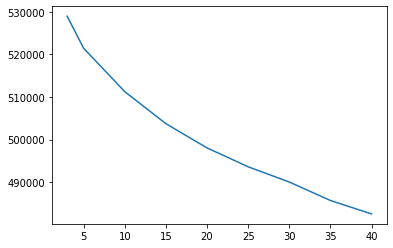

In [10]:
plt.plot(list(elbow.keys()), list(elbow.values())) 

In [ ]:
# Our Function
Y = pd.DataFrame(Y)
k = 10
clusters = KM(Y, k)

In [ ]:
# sklearn implementation
model = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
model.fit(Y)